<a href="https://colab.research.google.com/github/ucfilho/ANN/blob/master/ANN_2022/Image_07/class_007_image_processing_blood_cells_005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, ZeroPadding2D, MaxPool2D, Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import cv2
import numpy as np

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

import zipfile
import pandas as pd


from sklearn.metrics import classification_report, confusion_matrix

In [3]:
IMAGE_SIZE = [224,224]
ImgSize = IMAGE_SIZE[0]
epochs = 16
batch_size = 128

In [4]:
!gdown 1CU4UkqJae07u1tKfp2rajWwwZA0SKiIm

Downloading...
From: https://drive.google.com/uc?id=1CU4UkqJae07u1tKfp2rajWwwZA0SKiIm
To: /content/blood_cell_images.zip
100% 110M/110M [00:00<00:00, 370MB/s] 


In [5]:
FILE='blood_cell_images.zip'

In [6]:
archive = zipfile.ZipFile(FILE, 'r')
archive.extractall()

In [7]:
!ls

blood_cell_images  blood_cell_images.zip  __MACOSX  sample_data


In [8]:
train_path = 'blood_cell_images/TRAIN'
test_path = 'blood_cell_images/TEST'
images_test = glob(test_path + '/*/*.jp*g')
images_train = glob(train_path + '/*/*.jp*g')

In [9]:
folders_train = glob(train_path + '/*')
folders_test = glob(test_path + '/*')

In [10]:
folders_train

['blood_cell_images/TRAIN/LYMPHOCYTE',
 'blood_cell_images/TRAIN/MONOCYTE',
 'blood_cell_images/TRAIN/EOSINOPHIL',
 'blood_cell_images/TRAIN/NEUTROPHIL']

In [11]:
folders_test

['blood_cell_images/TEST/LYMPHOCYTE',
 'blood_cell_images/TEST/MONOCYTE',
 'blood_cell_images/TEST/EOSINOPHIL',
 'blood_cell_images/TEST/NEUTROPHIL']

In [12]:
ntrain, ntest = len(images_train),len(images_test)
ntrain,ntest

(9957, 2487)

In [13]:
images_train[:4]

['blood_cell_images/TRAIN/LYMPHOCYTE/_16_9693.jpeg',
 'blood_cell_images/TRAIN/LYMPHOCYTE/_9_3547.jpeg',
 'blood_cell_images/TRAIN/LYMPHOCYTE/_18_293.jpeg',
 'blood_cell_images/TRAIN/LYMPHOCYTE/_11_2363.jpeg']

In [14]:
types = ['NEUTROPHIL', 'EOSINOPHIL', 'MONOCYTE', 'LYMPHOCYTE']

In [15]:

def load_images(images,types=types):

  nsize = len(images)
  X =[]
  y =[]
  names =[]
  k = 0

  for i in range(nsize): 
    img = image.load_img(images[i])
    im = cv2.resize(np.array(img), (224, 224))
    im = preprocess_input(im)
    k += 1
    if( k % 3 == 0):
      X.append(im)

      if(types[0] in images[i]):
        names.append(types[0])
        y.append(0)
      elif(types[1] in images[i]):
        names.append(types[1])
        y.append(1)
      elif(types[2] in images[i]):
        names.append(types[2])
        y.append(2)
      else:
        names.append(types[3])
        y.append(3)

  X =np.array(X)
  return X,y,names

In [16]:

X_train, y_train, names_train = load_images(images_train)
X_test, y_test, names_test = load_images(images_test)

In [17]:
X_train[0].shape

(224, 224, 3)

In [18]:
df = pd.DataFrame({'name':names_train,'class':y_train})
y_train = pd.get_dummies(df['class'])
y_train

,0,1,2,3
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
3314,1,0,0,0
3315,1,0,0,0
3316,1,0,0,0
3317,1,0,0,0


In [19]:
for i in range(4): 
  df_plot= df[(df["class"] == i)]
  n= df_plot.shape[0]
  print(types[i],n)

NEUTROPHIL 833
EOSINOPHIL 833
MONOCYTE 826
LYMPHOCYTE 827


In [20]:
df = pd.DataFrame({'name':names_test,'class':y_test})
y_test = pd.get_dummies(df['class'])
y_test

,0,1,2,3
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
824,1,0,0,0
825,1,0,0,0
826,1,0,0,0
827,1,0,0,0


In [21]:
from keras.applications.mobilenet_v2 import MobileNetV2
model = MobileNetV2(weights='imagenet')

In [22]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 30

# Freeze all the layers before the `fine_tune_at` layer
# check https://www.tensorflow.org/tutorials/images/transfer_learning
for layer in model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  156


In [23]:
D =len(types)
model_output = Dense(D, activation= 'softmax') #'relu')
model_output = model_output(model.layers[-2].output)
model_input = model.input
model_new = Model(inputs=model_input, outputs=model_output)
#for layer in model_new.layers[:-1]:
#    layer.trainable = False

In [24]:
base_learning_rate = 0.0001
model_new.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [25]:
r = model_new.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    verbose=2
)

Epoch 1/30
104/104 - 22s - loss: 1.2404 - accuracy: 0.4384 - val_loss: 1.7171 - val_accuracy: 0.3076 - 22s/epoch - 207ms/step
Epoch 2/30
104/104 - 10s - loss: 0.7911 - accuracy: 0.7409 - val_loss: 1.8554 - val_accuracy: 0.3052 - 10s/epoch - 96ms/step
Epoch 3/30
104/104 - 10s - loss: 0.4747 - accuracy: 0.8729 - val_loss: 1.8952 - val_accuracy: 0.3583 - 10s/epoch - 97ms/step
Epoch 4/30
104/104 - 10s - loss: 0.2919 - accuracy: 0.9274 - val_loss: 1.8027 - val_accuracy: 0.4138 - 10s/epoch - 99ms/step
Epoch 5/30
104/104 - 10s - loss: 0.1876 - accuracy: 0.9590 - val_loss: 1.7057 - val_accuracy: 0.4644 - 10s/epoch - 97ms/step
Epoch 6/30
104/104 - 11s - loss: 0.1162 - accuracy: 0.9813 - val_loss: 1.5702 - val_accuracy: 0.5163 - 11s/epoch - 102ms/step
Epoch 7/30
104/104 - 10s - loss: 0.0773 - accuracy: 0.9861 - val_loss: 1.4160 - val_accuracy: 0.5766 - 10s/epoch - 100ms/step
Epoch 8/30
104/104 - 10s - loss: 0.0494 - accuracy: 0.9940 - val_loss: 1.2867 - val_accuracy: 0.6224 - 10s/epoch - 96ms/st

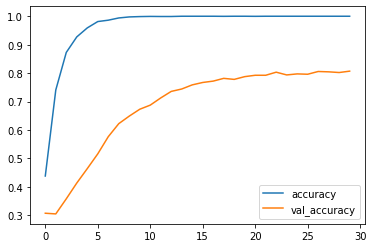

In [26]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

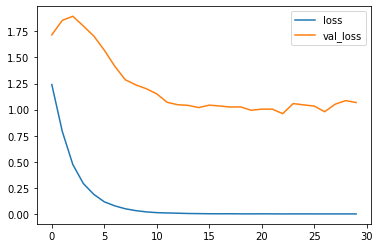

In [27]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()